In [74]:
import csv
from io import StringIO

import pandas as pd
from matplotlib import pyplot as plt
from pandas import Series

Reading the raw dataset. Some rows (e.g. line 1010) contain complex nested quotes and commas, which requires modifying each line before passing it to `pandas.read_csv()`. The outer quotes get replaced by an arbitrary (`\u2603`, the snowman) character, which is then specified as the quote character used for parsing.

In [75]:
csv.field_size_limit(4 * 131072)  # 4 times the default

with open("../raw/webis_bias_flipper_18.csv", mode="r", encoding="utf-8") as file:
    modified_lines = (
        "\u2603".join(line.replace("\",\"", "\u2603,\u2603").replace("\"", "\u2603", 1).rsplit("\"", 1))
        for line in file
    )
    df = pd.read_csv(StringIO("".join(modified_lines)), quotechar="\u2603", encoding="utf-8", engine="python")
df

,story_id,bias,title,body,source,original_title,original_body
0,0,From the Right,Report: DACA-age illegals far more likely to c...,A new report about crimes committed by illegal...,Washington Examiner,Report: DACA-age illegals far more likely to c...,A new report about crimes committed by illegal...
1,0,From the Left,Trump’s claim that immigrants bring ‘tremendou...,Trump earned Four Pinocchios the last time we ...,Washington Post,Trump’s claim that immigrants bring ‘tremendou...,“The Democrats are really looking at something...
2,1,From the Left,"Trump Accuses His Justice Department, FBI Of F...",Many of them are actually Republicans.,HuffPost,"Trump Accuses His Justice Department, FBI Of F...",In his latest unprecedented attack on federal ...
3,1,From the Center,"Trump accuses FBI, Justice Department of polit...",President Donald Trump attacked the integrity ...,Reuters,Explosive memo released as Trump escalates fig...,WASHINGTON (Reuters) - President Donald Trump ...
4,1,From the Right,"Trump accuses FBI, DOJ leadership of bias agai...",President Trump said Friday the leaders at the...,Washington Times,"Trump accuses FBI, DOJ leadership of bias agai...",President Trump said Friday the leaders at the...
...,...,...,...,...,...,...,...
6443,2779,From the Center,"Obama, Romney Duel On Economy In Ohio Where It...",Ohio could very well be the state where what's...,NPR News,"Obama, Romney Duel On The Economy In Ohio, Whe...",Ohio could very well be the state where what's...
6444,2779,From the Right,"Dueling speeches: Obama, Romney target Ohio","Dueling from down the road, President Obama an...",Washington Times,"Dueling speeches: Obama, Romney target Ohio","WASHINGTON (AP) — Dueling from down the road, ..."
6445,2780,From the Left,John Edwards Trial: 7 ways he can rebuild,John Edwards walked out of court Thursday a fr...,Politico,7 ways Edwards can rebuild,Updated 06/01/2012 01:59 PM EDT John Edwards w...
6446,2780,From the Right,"After mistrial in Edwards case, law enforcemen...",John Edwards walks -- at least for now.,Fox News,"After mistrial in Edwards case, law enforcemen...",John Edwards walks -- at least for now. The fa...


Comparison of the body column (from AllSides) versus the original body column (from the news portals). The text volume of the original columns is much higher, probably because AllSides cuts the length. This means the title and body columns can be dropped and the original ones will be used.

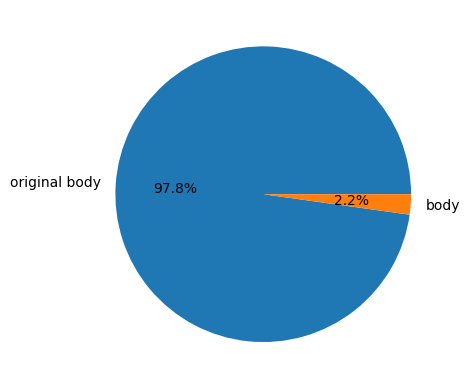

In [76]:
pd.Series(
    [df["original_body"].str.len().sum(), df["body"].str.len().sum()],
    index=["original body", "body"]
).plot.pie(autopct="%1.1f%%");

Dropping useless columns.

In [77]:
df = df.drop(columns=["story_id", "title", "body", "source"])

Renaming and reordering columns.

In [78]:
df = df.rename(columns={"original_title": "title", "original_body": "body", "bias": "leaning"})
df = df[["title", "body", "leaning"]].copy()

Categorizing the leaning column.

In [79]:
df["leaning"] = df["leaning"].astype("category")
df["leaning"] = df["leaning"].cat.rename_categories(
    {"From the Left": "left", "From the Center": "center", "From the Right": "right"}
)

Dropping rows with missing data.

In [80]:
df = df.dropna(subset=["body", "leaning"])

Printing duplicates.

In [81]:
df[df["body"].duplicated(keep=False)]

,title,body,leaning
466,U.S. states sue to block Trump Obamacare subsi...,WASHINGTON/SAN FRANCISCO (Reuters) - Eighteen ...,center
477,U.S. states sue to block Trump Obamacare subsi...,WASHINGTON/SAN FRANCISCO (Reuters) - Eighteen ...,center
918,Rand Paul and 3 Others Reject Senate GOP Healt...,"WASHINGTON -- Sen. Rand Paul, R-Ky., says he a...",right
925,Rand Paul and 3 Others Reject Senate GOP Healt...,"WASHINGTON -- Sen. Rand Paul, R-Ky., says he a...",right
965,Highlights from Attorney General Jeff Sessions...,Attorney General Jeff Sessions engaged in high...,left
...,...,...,...
6302,"A Fine Night For Romney, But No Game Change",It's been the political world's obsession for ...,center
6327,Romney Reboot? Convention Could Be The Ticket,"Mitt Romney, 65, has spent the better part of ...",center
6330,Romney Reboot? Convention Could Be The Ticket,"Mitt Romney, 65, has spent the better part of ...",center
6378,Jobs numbers better than expected,Updated 08/03/2012 01:41 PM EDT Job growth in ...,left


Dropping the duplicates.

In [82]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [83]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,title,body,leaning,body_length,body_word_count
5006,Cruz: Harry Reid Unwilling to Compromise Over ...,Story continues below video.,right,28,4
3229,President Obama Is Fired Up and Ready to Tweet,"— President Obama (@POTUS) May 18, 2015",left,39,7
3075,Happy 4th of July: Americans Worry About Terro...,Keep up with this story and more by subscribin...,left,51,10
4876,Rand Paul: Moderate Like Christie Has Little C...,See the Steve Malzberg Show on Newsmax TV each...,right,80,15
3165,State Dept. spokeswoman sparks Twitter war wit...,"[View the story """"Harf sparks Twitter war with...",center,89,15


After inspection, articles with bodies shorter than 15 words seem to contain no political value. Removing them.

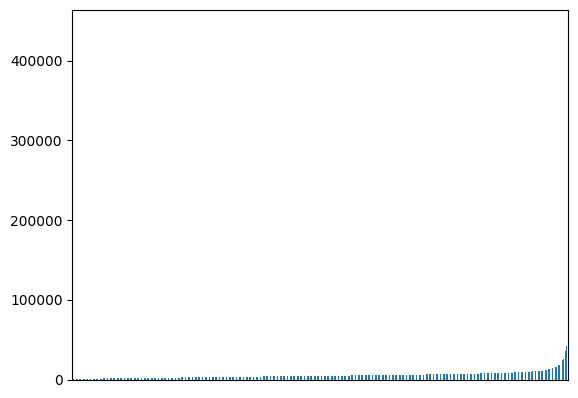

In [84]:
body_word_count_lower_bound = 15
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::10], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [85]:
df["body_length"].mean()

np.float64(5390.6144597126795)

The leaning distribution.

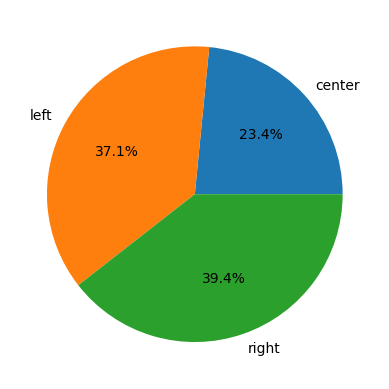

In [86]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

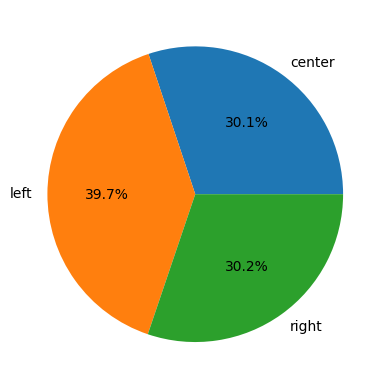

In [87]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

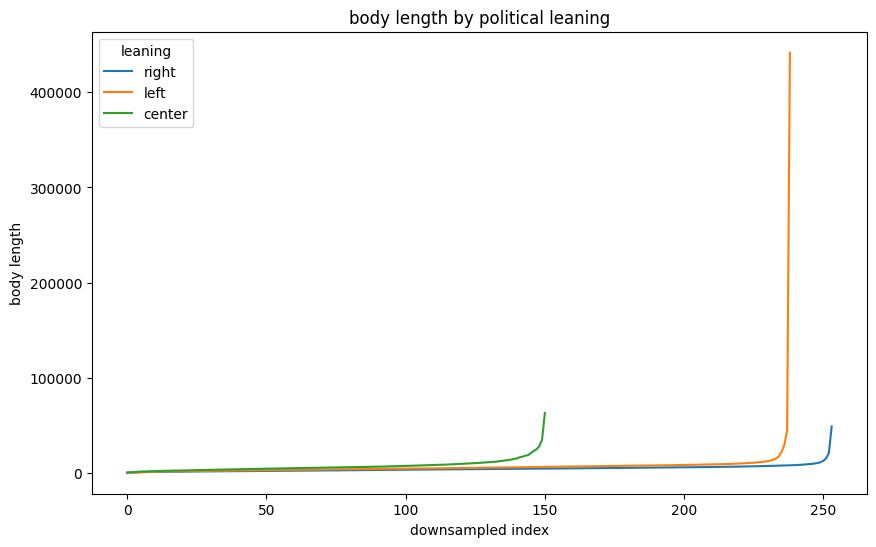

In [88]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::10], Series(df_leaning["body_length"].tail(1))]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [89]:
df.to_parquet("../preprocessed/webis_bias_flipper_18.parquet")